# DENOISING MODEL USING 3 DIFFERENT TYPES OF LOSSES
1. HYBRID (SSIM + MAE)
2. MSE
3. SSIM

In [95]:
import cv2
import numpy as np
import os
import glob

# Define paths
BASE_PATH = "C:/Users/Admin/Desktop/archive/images"  # Original images
OUTPUT_PATH = "C:/Users/Admin/Desktop/archive/noisy_images"  # Folder to save noisy images

# Define Gaussian noise levels
NOISE_LEVELS = {
    "gaussian_low": 30,    # Low Noise
    "gaussian_medium": 50, # Medium Noise
    "gaussian_high": 80    # High Noise
}
def add_poisson_noise(image,scale=2):
    noisy_img = np.random.poisson(image.astype(np.float32)*scale)  # Apply Poisson noise
    noisy_img = np.clip(noisy_img, 0, 255).astype(np.uint8)  # Keep values in range, back to usual format
    return noisy_img
# Function to add Gaussian noise
def add_gaussian_noise(image, std):
    noise = np.random.normal(0, std, image.shape).astype(np.int16)  # Generate noise
    noisy_img = np.clip(image.astype(np.int16) + noise, 0, 255).astype(np.uint8)  # Add noise and clip
    return noisy_img

# Process images for train, val, test
for split in ["train", "val", "test"]:
    input_folder = os.path.join(BASE_PATH, split)  # Input images path

    # Create noise folders if they don’t exist
    for noise_type in NOISE_LEVELS.keys():
        output_folder = os.path.join(OUTPUT_PATH, split, noise_type)
        os.makedirs(output_folder, exist_ok=True)

    # Process each image
    # GLOB search for files; "*.jpg": only look for files that end with .jpg 
    img_paths = glob.glob(os.path.join(input_folder, "*.jpg"))  # Get all images
    for img_path in img_paths:
        img = cv2.imread(img_path) # IN BGR
        img = cv2.resize(img, (256, 256))  # Resize for consistency FROM (481,321,3)

        filename = os.path.basename(img_path)  # Extract filename 

        # Apply noise at different levels and save
        for noise_type, std in NOISE_LEVELS.items():
            noisy_img = add_gaussian_noise(img, std)
            save_path = os.path.join(OUTPUT_PATH, split, noise_type, filename)
            cv2.imwrite(save_path, noisy_img)  # Save image
    
    for img_path in img_paths:
        output_folder = os.path.join(OUTPUT_PATH, split,'poisson')
        os.makedirs(output_folder, exist_ok=True)
        img = cv2.imread(img_path) 
        img = cv2.resize(img, (256, 256))  # Resize for consistency
        noisy_img = add_poisson_noise(img) # Apply Poisson noise
        
        filename = os.path.basename(img_path)
        save_path = os.path.join(OUTPUT_PATH, split, 'poisson',filename)
        cv2.imwrite(save_path, noisy_img)

print("\n🎉 Gaussian noise applied and images saved successfully in the correct folders!")


🎉 Gaussian noise applied and images saved successfully in the correct folders!


In [96]:
import os
import cv2
import numpy as np

def load_all_noisy_images(clean_folder, noisy_parent_folder, noise_types, target_size=(256, 256)):
    clean_images, noisy_images = [], []

    # Loop through the clean images folder
    for filename in os.listdir(clean_folder): #LISTDIR: list of all files and folders 
        clean_path = os.path.join(clean_folder, filename)
        clean_img = cv2.imread(clean_path)
        if clean_img is None:
            continue
        clean_img = cv2.resize(clean_img, target_size) / 255.0  # Normalize

        # Loop through all noise types for each image (same for train, val, test)
        for noise_type in noise_types:
            noisy_path = os.path.join(noisy_parent_folder, noise_type, filename)
            noisy_img = cv2.imread(noisy_path)

            if noisy_img is not None:
                noisy_img = cv2.resize(noisy_img, target_size) / 255.0  # Normalize
                clean_images.append(clean_img)
                noisy_images.append(noisy_img)

    return np.array(clean_images), np.array(noisy_images)

In [97]:
# List of all noise types
noise_types = ["gaussian_low", "gaussian_medium", "gaussian_high", "poisson"]

# Load training data
train_clean, train_noisy = load_all_noisy_images(
    "C:/Users/Admin/Desktop/archive/images/train",
    "C:/Users/Admin/Desktop/archive/noisy_images/train",
    noise_types
)

# Load validation data
val_clean, val_noisy = load_all_noisy_images(
    "C:/Users/Admin/Desktop/archive/images/val",
    "C:/Users/Admin/Desktop/archive/noisy_images/val",
    noise_types
)

# Load test data
test_clean, test_noisy = load_all_noisy_images(
    "C:/Users/Admin/Desktop/archive/images/test",
    "C:/Users/Admin/Desktop/archive/noisy_images/test",
    noise_types
)

In [99]:
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Add,Dropout
def build_unet(input_shape=(256, 256, 3)):
    inputs = layers.Input(shape=input_shape)

# Encoder (Downsampling)
    c1 = layers.Conv2D(128, (3, 3), padding='same')(inputs)
    c1 = layers.LeakyReLU(alpha=0.2)(c1)
    c1 = layers.Conv2D(128, (3, 3), padding='same')(c1)
    c1 = layers.LeakyReLU(alpha=0.2)(c1) #sharpness
    c1 = layers.BatchNormalization()(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1) # Down sampling
    p1 = Dropout(0.2)(p1)

    c2 = layers.Conv2D(256, (3, 3), padding='same')(p1)
    c2 = layers.LeakyReLU(alpha=0.2)(c2)
    c2 = layers.Conv2D(256, (3, 3), padding='same')(c2)
    c2 = layers.LeakyReLU(alpha=0.2)(c2)
    c2 = layers.BatchNormalization()(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)
    p2 = Dropout(0.2)(p2)

    c3 = layers.Conv2D(512, (3, 3), padding='same')(p2)
    c3 = layers.LeakyReLU(alpha=0.2)(c3)
    c3 = layers.Conv2D(512, (3, 3), padding='same')(c3)
    c3 = layers.LeakyReLU(alpha=0.2)(c3)
    c3 = layers.BatchNormalization()(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)
    p3 = Dropout(0.2)(p3)

    c4 = layers.Conv2D(1024, (3, 3), padding='same')(p3)
    c4 = layers.LeakyReLU(alpha=0.2)(c4)
    c4 = layers.Conv2D(1024, (3, 3), padding='same')(c4)
    c4 = layers.LeakyReLU(alpha=0.2)(c4)
    c4 = layers.BatchNormalization()(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)
    p4 = Dropout(0.2)(p4)

    # Bottleneck
    b = layers.Conv2D(2048, (3, 3), padding='same')(p4)
    b = layers.LeakyReLU(alpha=0.2)(b)
    b = layers.Conv2D(2048, (3, 3), padding='same')(b)
    b = layers.LeakyReLU(alpha=0.2)(b)
    b = layers.BatchNormalization()(b)

    # Decoder (Upsampling + Skip Connections)
    u1 = layers.Conv2DTranspose(1024, (3, 3), strides=(2, 2), padding='same')(b)
    u1 = layers.Concatenate()([u1, c4])
    u1 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(u1)

    u2 = layers.Conv2DTranspose(512, (3, 3), strides=(2, 2), padding='same')(u1)
    u2 = layers.Concatenate()([u2, c3])
    u2 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u2)

    u3 = layers.Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same')(u2)
    u3 = layers.Concatenate()([u3, c2])
    u3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u3)

    u4 = layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same')(u3) #doubles the size of the image
    u4 = layers.Concatenate()([u4, c1]) #skip connection
    u4 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u4)

    # Output Layer (Use 1 filter for grayscale, 3 for RGB)
    outputs = layers.Conv2D(3, (1, 1), activation='sigmoid')(u4)

    model = models.Model(inputs, outputs)
    return model

model = build_unet()
model.summary()


Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_47 (Conv2D)              (None, 256, 256, 128 3584        input_5[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_2 (LeakyReLU)       (None, 256, 256, 128 0           conv2d_47[0][0]                  
__________________________________________________________________________________________________
conv2d_48 (Conv2D)              (None, 256, 256, 128 147584      leaky_re_lu_2[0][0]              
____________________________________________________________________________________________

In [100]:
import tensorflow as tf

def hybrid_loss(y_true, y_pred):
    """Combines SSIM loss and MAE loss."""
    ssim_loss = 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0)) # average of all the values.
    mae_loss = tf.keras.losses.MAE(y_true, y_pred)
    return 0.7 * ssim_loss + 0.3 * mae_loss

def ssim_metric(y_true, y_pred):
    return tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))


In [101]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4) #model learn faster and more smoothly.

In [102]:
model.compile(optimizer=optimizer , loss=hybrid_loss, metrics=[ssim_metric])

In [103]:
model.fit(train_noisy,
          train_clean,
          epochs=100,
          batch_size=8,
          validation_data=(val_noisy, val_clean)
)

Epoch 1/100
100/100 [==============================] - 44s 373ms/step - loss: 0.3351 - ssim_metric: 0.5706 - val_loss: 0.5021 - val_ssim_metric: 0.3679
Epoch 2/100
100/100 [==============================] - 37s 374ms/step - loss: 0.2801 - ssim_metric: 0.6429 - val_loss: 0.4863 - val_ssim_metric: 0.3838
Epoch 3/100
100/100 [==============================] - 37s 375ms/step - loss: 0.2541 - ssim_metric: 0.6754 - val_loss: 0.4291 - val_ssim_metric: 0.4571
Epoch 4/100
100/100 [==============================] - 38s 377ms/step - loss: 0.2451 - ssim_metric: 0.6877 - val_loss: 0.3554 - val_ssim_metric: 0.5436
Epoch 5/100
100/100 [==============================] - 38s 378ms/step - loss: 0.2333 - ssim_metric: 0.7025 - val_loss: 0.3092 - val_ssim_metric: 0.6048
Epoch 6/100
100/100 [==============================] - 38s 379ms/step - loss: 0.2256 - ssim_metric: 0.7115 - val_loss: 0.2817 - val_ssim_metric: 0.6412
Epoch 7/100
100/100 [==============================] - 38s 379ms/step - loss: 0.2238 - s

In [105]:
model.evaluate(test_noisy, test_clean)

25/25 [==============================] - 16s 343ms/step - loss: 0.1918 - ssim_metric: 0.7456


[0.19181028008460999, 0.7455828785896301]

In [54]:
print("Noisy Image Shape:", noisy_img.shape, "Range:", noisy_img.min(), noisy_img.max())

Noisy Image Shape: (256, 3, 3) Range: 0.3686274509803922 0.9803921568627451


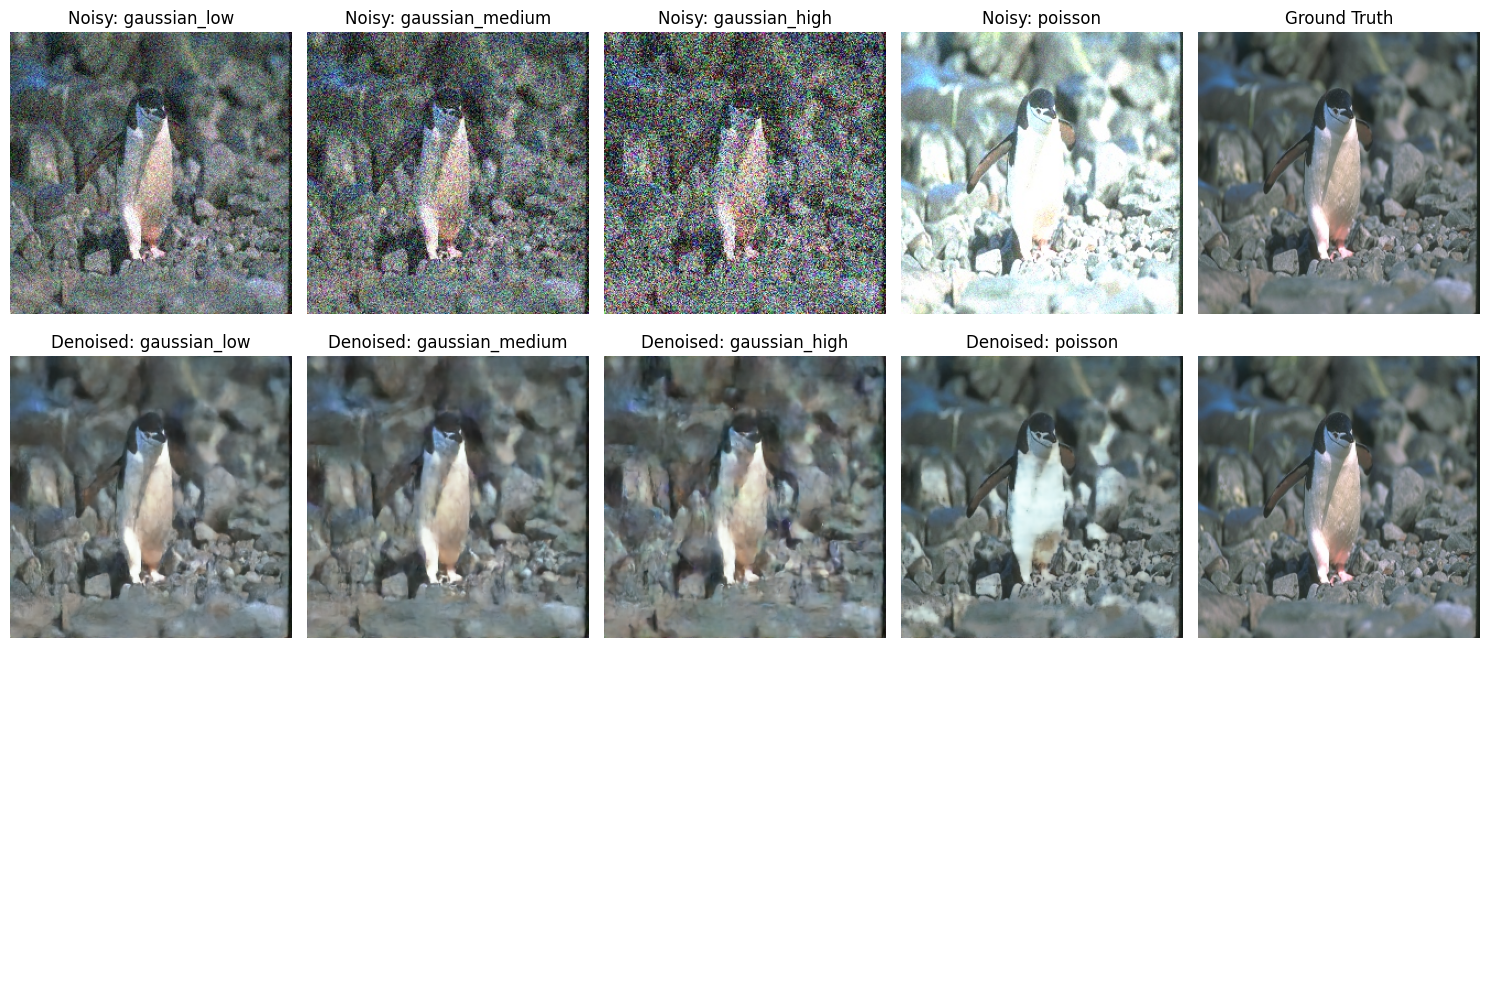

In [110]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2

# Define paths
clean_folder = "C:/Users/Admin/Desktop/archive/images/test"
noisy_parent_folder = "C:/Users/Admin/Desktop/archive/noisy_images/test"
noise_types = ["gaussian_low", "gaussian_medium", "gaussian_high", "poisson"]

# Select an image file that exists in all noise folders
image_filenames = os.listdir(clean_folder)  # Get all available images
selected_filename = image_filenames[14]  # Pick one image (change index if needed)

# Load the clean image (Ground Truth) and convert to RGB
clean_img = cv2.imread(os.path.join(clean_folder, selected_filename))
clean_img = cv2.cvtColor(clean_img, cv2.COLOR_BGR2RGB)  # Fix color issue
clean_img = cv2.resize(clean_img, (256, 256))

# Load noisy images and denoise them
noisy_imgs = {}
denoised_imgs = {}

for noise in noise_types:
    noisy_path = os.path.join(noisy_parent_folder, noise, selected_filename)
    noisy_img = cv2.imread(noisy_path)
    
    if noisy_img is not None:
        noisy_img = cv2.resize(noisy_img, (256, 256))
        noisy_img = cv2.cvtColor(noisy_img, cv2.COLOR_BGR2RGB)  # Fix color issue
        noisy_imgs[noise] = noisy_img / 255.0  # Normalize
    
        # Denoise using the model
        denoised_img = model.predict(noisy_imgs[noise][np.newaxis, ...])[0]
        denoised_img = np.clip(denoised_img, 0, 1)  # Ensure range [0,1]
        denoised_imgs[noise] = (denoised_img * 255).astype(np.uint8)  # Convert to uint8
    else:
        print(f"Warning: {noise} image not found for {selected_filename}")

# Convert clean image to uint8 (0-255) for display
clean_img = (clean_img).astype(np.uint8)

# Create a figure with subplots
fig, axes = plt.subplots(3, len(noise_types) + 1, figsize=(15, 10))

# Titles for the columns
titles = list(noise_types) + ["Ground Truth"]

# Display noisy images
for i, noise in enumerate(noise_types):
    if noise in noisy_imgs:
        axes[0, i].imshow(noisy_imgs[noise])
        axes[0, i].set_title(f"Noisy: {noise}")
    axes[0, i].axis("off")

# Display denoised images
for i, noise in enumerate(noise_types):
    if noise in denoised_imgs:
        axes[1, i].imshow(denoised_imgs[noise])
        axes[1, i].set_title(f"Denoised: {noise}")
    axes[1, i].axis("off")

# Display ground truth in the last column (fixed color)
axes[0, -1].imshow(clean_img)
axes[0, -1].set_title("Ground Truth")
axes[0, -1].axis("off")

axes[1, -1].imshow(clean_img)
axes[1, -1].axis("off")

# Remove empty bottom row
for i in range(len(noise_types) + 1):
    axes[2, i].axis("off")

plt.tight_layout()
plt.show()


In [104]:
model.save("denoising_model_hybrid100.keras")  # Replace E:/ with your external drive path


SSIM

In [ ]:
import tensorflow as tf

def ssim_loss(y_true, y_pred):
    return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))

In [ ]:
model.compile(optimizer='adam', loss = ssim_loss)

MSE

In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error')